Code for reproducing figure 2 comparison plots across different simulation configurations

Comparison version showing all configurations side-by-side for easy visual comparison.

Eleanor Holton 27/03/2025

In [22]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Get notebook's directory and find project root (transfer-interference directory)
try:
    # Try to get notebook path (works in Jupyter)
    notebook_path = Path(__file__).parent if '__file__' in globals() else Path.cwd()
except:
    notebook_path = Path.cwd()

# Navigate up to find project root (directory containing 'src' and 'data')
project_root = Path(notebook_path).resolve()
while not (project_root / 'src').exists() or not (project_root / 'data').exists():
    if project_root == project_root.parent:  
        # If we can't find it, assume we're in notebooks folder
        project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
        break
    project_root = project_root.parent

# Add project root to Python path
sys.path.insert(0, str(project_root))

# Setup figure output path
figure_path = project_root / 'figures/figure2_transfer_interference_comparison'
os.makedirs(figure_path, exist_ok=True)

# Create matplotlib cache directory and clear font cache to pick up font changes
try:
    cache_dir = Path.home() / '.cache' / 'matplotlib'
    cache_dir.mkdir(parents=True, exist_ok=True)
    matplotlib.font_manager._load_fontmanager(try_read_cache=False)
except Exception as e:
    print(f"Note: Could not clear font cache: {e}")

from src.analysis import participant, ann, stats
from src.utils import figure_utils, figure_settings
from src.utils.figure_settings import schedule_colours, cm_conv, med_fontsize, condition_order

import importlib
importlib.reload(figure_settings)
importlib.reload(ann)
importlib.reload(participant)
importlib.reload(figure_utils)
importlib.reload(stats)

<module 'src.analysis.stats' from '/home/kathrin/workspace/Structure-Function-Analysis-of-Network-Topologies/transfer-interference/src/analysis/stats.py'>

In [ ]:
# Define configurations to compare
sim_configs = ['lazy_50', 'gamma_1_50', 'standard_50', 'gamma_e_1_50', 'gamma_5e_2_50', 'gamma_e_2_50', 'rich_50']

# Load human data
participant_data = pd.read_csv(project_root / 'data/participants/trial_df.csv')

# Load all simulation data
ann_data_dict = {}
ann_vonmises_dict = {}
for config in sim_configs:
    config_path = project_root / f'data/simulations/{config}'
    if config_path.exists():
        ann_data_dict[config] = ann.load_ann_data(config_path)
        vonmises_path = project_root / f'data/simulations/{config}_vonmises_fits.csv'
        if vonmises_path.exists():
            ann_vonmises_dict[config] = pd.read_csv(vonmises_path)
    else:
        print(f"Warning: {config} data not found, skipping...")

## Transfer analyses - Comparison across configurations

In [ ]:
# Compute transfer for humans
human_transfer = participant.compute_transfer_humans(participant_data)

# Compute transfer for all ANN configurations
ann_transfer_dict = {}
for config in sim_configs:
    if config in ann_data_dict:
        ann_transfer_dict[config] = ann.compute_transfer_anns(ann_data_dict[config])

In [ ]:
        # Create comparison plot for transfer
# 2x4 grid: humans + 7 ANN configurations
fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])

# Plot humans (first subplot)
ax = axes[0, 0]
figure_utils.plot_transfer(
    human_transfer, 'error_diff', condition_order, 
    ylabel='Task B switch cost\n(Δ accuracy)', 
    xlim=(-0.5, 2.5), ylim=(-1.1, 0.5), 
    yticks=np.arange(-1, 0.3, 0.5), 
    schedule_colours=schedule_colours, 
    p_values=np.nan, addtests=0, ax=ax
)
ax.set_title('Humans', fontsize=8)
ax.xaxis.label.set_fontsize(7)
ax.yaxis.label.set_fontsize(7)
ax.tick_params(labelsize=7)

# Plot each ANN configuration
for idx, config in enumerate([c for c in sim_configs if c in ann_transfer_dict], start=1):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    figure_utils.plot_transfer(
        ann_transfer_dict[config], 'error_diff', condition_order,
        ylabel='Task B switch cost\n(Δ accuracy)',
        xlim=(-0.5, 2.5), ylim=(-1.1, 0.5),
        yticks=np.arange(-1, 0.3, 0.5),
        schedule_colours=schedule_colours,
        p_values=np.nan, addtests=0, ax=ax
    )
    ax.set_title(config, fontsize=8)
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)
    ax.tick_params(labelsize=7)

# Remove empty subplots if any
n_plotted = 1 + len([c for c in sim_configs if c in ann_transfer_dict])
for idx in range(n_plotted, 8):
    row = idx // 4
    col = idx % 4
    axes[row, col].set_visible(False)

plt.tight_layout()
fig.savefig(
    os.path.join(figure_path, 'fig2A_transfer_comparison.png'),
    dpi=500, bbox_inches="tight"
)
plt.close(fig)

## Interference analyses - Comparison across configurations

In [ ]:
# Load human von Mises fits
human_vonmises_params = pd.read_csv(project_root / 'data/participants/human_vonmises_fits.csv')
human_vonmises_filtered = human_vonmises_params.loc[
    human_vonmises_params['B_LL_B'] > human_vonmises_params['A_LL_B'], :
]

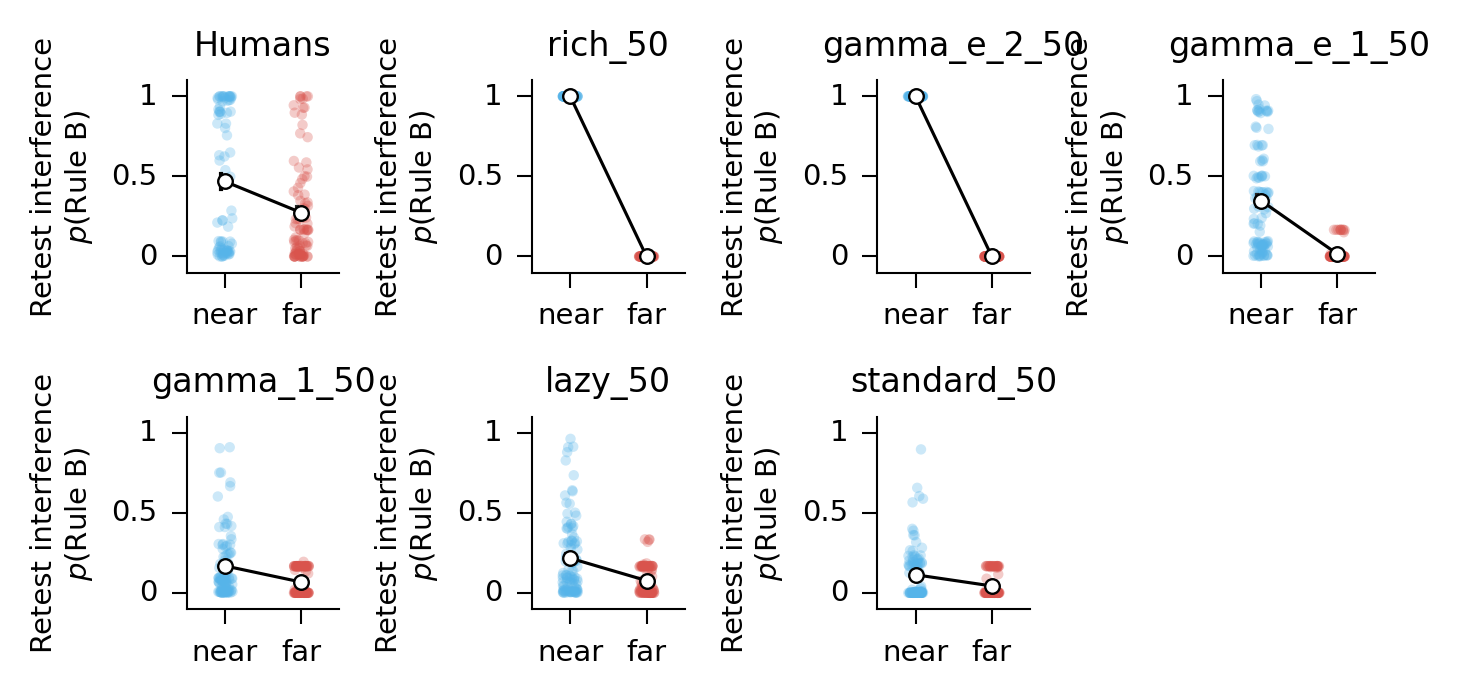

In [ ]:
# Create comparison plot for interference
# 2x4 grid: humans + 7 ANN configurations
fig, axes = plt.subplots(2, 4, figsize=[12*cm_conv, 6*cm_conv])

# Plot humans (first subplot)
ax = axes[0, 0]
figure_utils.plot_interference(
    human_vonmises_filtered,
    "A_weight_A2",
    schedule_colours,
    figsize=[3 * cm_conv, 4.5 * cm_conv],
    ylabel='Retest interference\n$p$(Rule B)',
    ax=ax
)
ax.set_title('Humans', fontsize=8)
ax.xaxis.label.set_fontsize(7)
ax.yaxis.label.set_fontsize(7)
ax.tick_params(labelsize=7)

# Plot each ANN configuration
for idx, config in enumerate([c for c in sim_configs if c in ann_vonmises_dict], start=1):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    figure_utils.plot_interference(
        ann_vonmises_dict[config],
        "A_weight_A2",
        schedule_colours,
        figsize=[3 * cm_conv, 4.5 * cm_conv],
        ylabel='Retest interference\n$p$(Rule B)',
        ax=ax
    )
    ax.set_title(config, fontsize=8)
    ax.xaxis.label.set_fontsize(7)
    ax.yaxis.label.set_fontsize(7)
    ax.tick_params(labelsize=7)

# Remove empty subplots if any
n_plotted = 1 + len([c for c in sim_configs if c in ann_vonmises_dict])
for idx in range(n_plotted, 8):
    row = idx // 4
    col = idx % 4
    axes[row, col].set_visible(False)

plt.tight_layout()


In [ ]:
fig.savefig(
    os.path.join(figure_path, 'fig2B_interference_comparison.png'),
    dpi=500, bbox_inches="tight"
)
plt.close(fig)